# COSC 4P96 Assignment 1: Supervised to Semi-Supervised Learning
Elias Switzer, 7419997

Set Parameters

In [ ]:
#Random seed
seed = 0

# Data processing and augmentation
scaling_min = 0 # set the min for min-max scaling
scaling_max = 1 # set the max for min-max scaling
p_horizonal_flip = 0.5 # probability of a horizontal flip
std_noise = 0.1 # standard deviation for distribution to sample added noise from

# Data splitting
train_split = 0.8
val_split = 0.1
labeled_split = 0.2 # percentage of training data to be labeled
initial_train_split = 0.75 # percentage of labeled data to train supervised network with

init_training_batch_size = 64 # for mini-batch training
init_validation_batch_size = 64

# Model parameters
epochs = 30 # number of epochs for training
lr = 0.01 # learning rate: experiment with values in [0.001, 0.1]
momentum = 0.9 # momentum value: experiment with values in [0.5, 0.99]
init_type = "he" # weight initialization: "random_uniform", "random_normal", or "he"
overfitting_window = 5 # number of previous epochs to check for overfitting


Imports and random seeds

In [13]:
import torch
torch.manual_seed(seed)

from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

Device configuration

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # will run on GPU if available
print("Using device: ", device)

Using device:  cuda


Load CIFAR-10 dataset

In [ ]:
transform = v2.Compose([
    v2.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Apply the data transformations

In [ ]:
from data_prep import compute_mean_std, compute_min_max, MinMaxScaling

data_mean, data_std = compute_mean_std(dataset)
data_min, data_max = compute_min_max(dataset)

dataset.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std), # Apply z-score normalization
    MinMaxScaling(data_min, data_max, scaling_min, scaling_max), # Apply min-max scaling to [0,1]

    v2.RandomHorizontalFlip(p=p_horizonal_flip),
    v2.RandomCrop((32,32)),
    v2.GaussianNoise(mean=0, sigma=std_noise),
    v2.ColorJitter()
])

Split data

In [ ]:
# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(seed)

# Split into training, validation and testing data
train_set, val_set, test_set = random_split(dataset, [train_split, val_split, 1-train_split-val_split], generator=generator)

# Split into labeled and unlabeled for semi-supervised setup
labeled_training_set, unlabeled_training_set = random_split(train_set, [labeled_split, 1-labeled_split], generator=generator)

# Split into initial training and validation (from the labeled data)
initial_training_set, initial_validation_set = random_split(labeled_training_set, [initial_train_split, 1-initial_train_split], generator=generator)

Preview the data

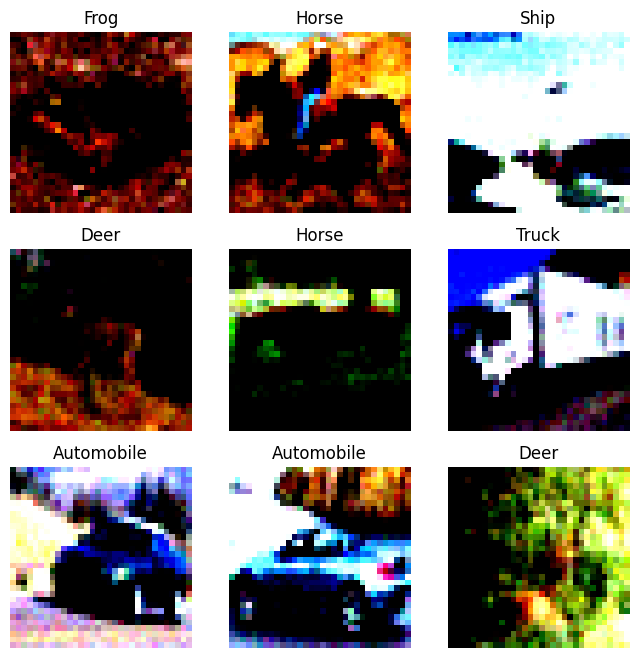

In [18]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

Create data loaders

In [ ]:
initial_train_loader = DataLoader(initial_training_set, batch_size=init_training_batch_size, shuffle=True) # specifying batch size > 1 ensures mini-batch gradient descent is used
initial_val_loader = DataLoader(initial_validation_set, batch_size=init_validation_batch_size)
test_loader = DataLoader(test_set, batch_size=64)

Configure supervised neural network, weight initialization, optimizer and loss function

In [39]:
from model_supervised import SupervisedNetwork, init_weights
import torch.nn as nn
import torch.optim as optim

model = SupervisedNetwork()
model.apply(lambda m: init_weights(m, type=init_type))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [40]:
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

Train and validate baseline supervised neural network (move to its own script)

In [41]:
converged_epoch = None

val_loss_history = [] # to track the previous val loss
early_stop = False

for epoch in range(epochs):
    if early_stop:
        break
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    for images, labels in initial_train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero gradients

        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)

        loss.backward() # backpropigate error
        optimizer.step() # update parameters

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in initial_val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    val_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | ",
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}"
    )
    
    # Record Metrics
    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["val_loss"].append(val_loss)
    metrics["val_acc"].append(val_acc)

    # Overfitting Detection
    val_loss_history.append(val_loss)
    if len(val_loss_history) > overfitting_window: # only start checking after enough epochs have passed
        prev_val_loss_values = val_loss_history[-overfitting_window:]

        mean_val_loss = np.mean(prev_val_loss_values)
        std__val_loss = np.std(prev_val_loss_values)

        if val_loss > mean_val_loss + std__val_loss: # overfitting criterion
            early_stop = True
            converged_epoch = epoch
            print("Overfitting Detected! Stopping training.")

if early_stop:
    print(f"Epoch Converged: {converged_epoch}")


Epoch [1/30] | Train Loss: 2.1836, Train Accuracy: 0.2223 |  Val Loss: 1.8951, Val Accuracy: 0.2925
Epoch [2/30] | Train Loss: 1.9240, Train Accuracy: 0.2708 |  Val Loss: 1.8614, Val Accuracy: 0.3175
Epoch [3/30] | Train Loss: 1.8337, Train Accuracy: 0.3007 |  Val Loss: 1.7880, Val Accuracy: 0.3515
Epoch [4/30] | Train Loss: 1.7927, Train Accuracy: 0.3308 |  Val Loss: 1.6060, Val Accuracy: 0.4015
Epoch [5/30] | Train Loss: 1.7346, Train Accuracy: 0.3512 |  Val Loss: 1.6184, Val Accuracy: 0.4210
Epoch [6/30] | Train Loss: 1.7102, Train Accuracy: 0.3657 |  Val Loss: 1.6931, Val Accuracy: 0.3985
Epoch [7/30] | Train Loss: 1.6617, Train Accuracy: 0.3822 |  Val Loss: 1.5234, Val Accuracy: 0.4345
Epoch [8/30] | Train Loss: 1.5951, Train Accuracy: 0.4068 |  Val Loss: 1.4860, Val Accuracy: 0.4640
Epoch [9/30] | Train Loss: 1.5515, Train Accuracy: 0.4313 |  Val Loss: 1.4868, Val Accuracy: 0.4655
Epoch [10/30] | Train Loss: 1.5413, Train Accuracy: 0.4287 |  Val Loss: 1.4961, Val Accuracy: 0.4695

Test model (move to its own script)

In [36]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

average_test_loss = test_loss / total
test_acc = correct / total

print(f"Average Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Average Test Loss: 1.4459, Test Accuracy: 0.5404


Visualize training and validation loss

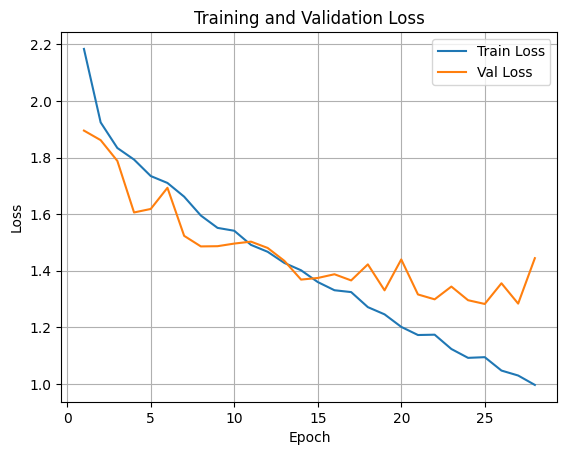

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(metrics['train_loss']) + 1)

plt.figure()
plt.plot(epochs, metrics["train_loss"], label="Train Loss")
plt.plot(epochs, metrics["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

Visualize training and validation accuracy

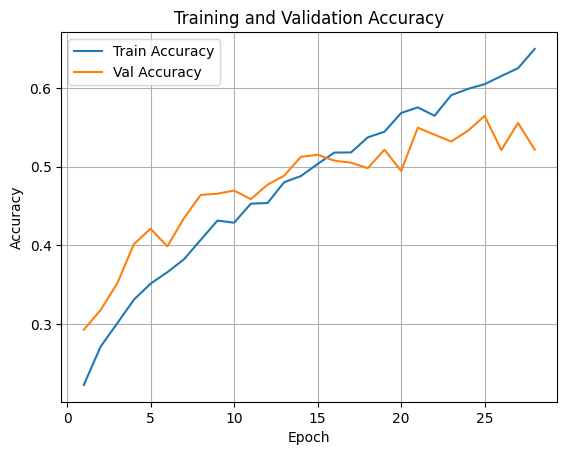

In [48]:
plt.figure()
plt.plot(epochs, metrics["train_acc"], label="Train Accuracy")
plt.plot(epochs, metrics["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)